# Integración con **PySpark**
Otra alternativa para poder integrar todo este proyecto en conjunto y dentro todo mismo usando python puede ser con [PySpark](https://spark.apache.org/docs/latest/api/python/index.html). A continuación se detalla lo necesario para poder trabajar con esta librería y se analiza esta opción.

## Uso
Para iniciar a usar pyspark, es necesario primero crear una sesión de la siguiente forma (es necesario tener **Java** instalado:

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/21 17:16:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


*Algunos *warnings* fueron arrojados, pero no parecen ser vitales.*

Pyspark trabaja de una manera más eficiente con `DataFrames` (usados también en Pandas) y estos pueden ser obtenidos a través de archivos que contengan fuentes de datos. En este caso, utilizarémos un ejemplo básico de un `geojson` (`JSON`).

### Leyendo `JSON` (`geojson`)
Una vez teniendo una sesión de PySpark es posible leer `JSON`s

In [2]:
geojson_df = spark.read.json("../assets/basic.json", multiLine=True)
geojson_df.show()
geojson_df.schema

+--------------------+---------------+
|         coordinates|           type|
+--------------------+---------------+
|[[[1.0, 2.0]], [[...|MultiLineString|
+--------------------+---------------+



StructType([StructField('coordinates', ArrayType(ArrayType(ArrayType(DoubleType(), True), True), True), True), StructField('type', StringType(), True)])

Casi de la misma forma que se leen los `JSON`s en `Python`. Es importante también considerar la bandera `multiLine`, ya que si no se establece esta, habrán errores de lectura.

In [3]:
# Leyendo json en Python
import json

with open('../assets/basic.json', 'r') as file:
    example_geojson = json.load(file)

example_geojson

{'type': 'MultiLineString', 'coordinates': [[[1.0, 2.0]], [[3.0, 4.0]]]}

### Cálculo de distancia euclideana
Teniendo el `JSON` (o `geojson`) cargado, se pueden definir funciones con las que PySpark podrá trabajar, denomidas [UDF (User Defined Functions)](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.functions.udf.html), para así poder definir una función que calcule la distancia euclideana de las coordenadas que nuestro `JSON` contenga.

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from math import sqrt

# Define UDF to calculate Euclidean distance
def euclidean_distance(coords):
    point1 = coords[0][0]
    point2 = coords[1][0]
    return float(sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2))

distance_udf = F.udf(euclidean_distance, FloatType())

geojson_df = geojson_df.withColumn('distance', distance_udf(F.col('coordinates')))
geojson_df.show(truncate=False)

+----------------------------+---------------+--------+
|coordinates                 |type           |distance|
+----------------------------+---------------+--------+
|[[[1.0, 2.0]], [[3.0, 4.0]]]|MultiLineString|2.828427|
+----------------------------+---------------+--------+



## Análisis
Ahora se verán los tiempos de ejecución que esta función tiene, para observar si realmente conviene el uso de Pyspark.

Primero se importan los `utils` que se tienen dentro del repositorio, para poder generar datos y graficar las respectivas gráficas.

In [5]:
import sys
import os.path

parent_dir = os.path.join(os.path.abspath(''), os.path.pardir)
sys.path.append(os.path.abspath(parent_dir))

De esta forma es posible importar, por ejemplo, la librería interna que se desarrollo para poder generar datos GeoJSON.

In [6]:
from utils import genjson

genjson.dataframe(1, spark).show(truncate=False)

+------------------------------------------------------------------------------------+---------------+
|coordinates                                                                         |type           |
+------------------------------------------------------------------------------------+---------------+
|[[[-99.1380484684832, 19.392009959244916], [-99.1112461047117, 19.423605002215044]]]|MultiLineString|
+------------------------------------------------------------------------------------+---------------+



### Gráficas de la distancia euclideana con PySpark
Ahora se adapta el algoritmo de distancia euclideana para poder utilizarlo con `n` puntos que representarán una trayectoria.

In [7]:
from pyspark.sql.types import DoubleType

def euclidean_distance(coords: list[list[list[float]]]):
    total_distance = 0.0

    p = coords[0][0]
    q = coords[0][1]

    for i in range(len(p)):
        total_distance += (q[i] - p[i])**2
    
    return float(sqrt(total_distance))

geojson_df = genjson.dataframe(4, spark)

distance_udf = F.udf(euclidean_distance, DoubleType())
# This does the calculation + adding a column in dataframe
geojson_df = geojson_df.withColumn('distance', distance_udf(F.col('coordinates')))
# Here calculation ends, proceeding to show dataframe with new column
geojson_df.show()

+--------------------+---------------+------------------+
|         coordinates|           type|          distance|
+--------------------+---------------+------------------+
|[[[-99.0558967729...|MultiLineString|0.4058493009999197|
+--------------------+---------------+------------------+



Y con esto es posible graficar con las funciones antes utilizadas en algunos otros análisis hechos.

24/07/21 17:16:16 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


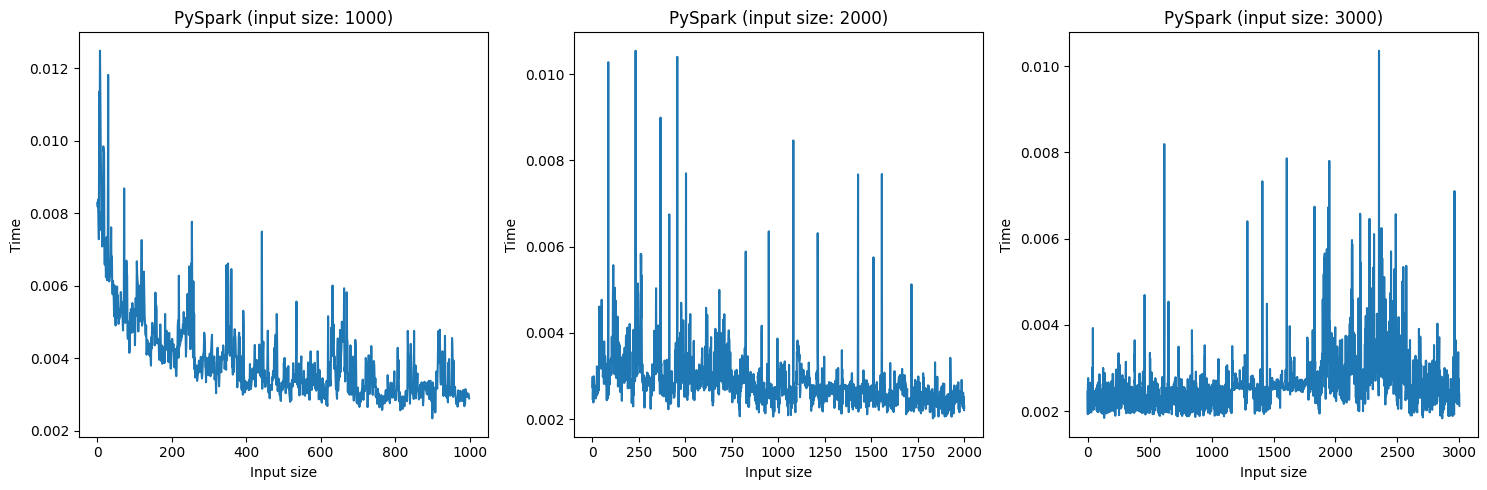

In [8]:
from utils import plotfn

plotfn.time_complexity3_spark(
    distance_udf,
    genjson.dataframe,
    spark,
    "PySpark",
)

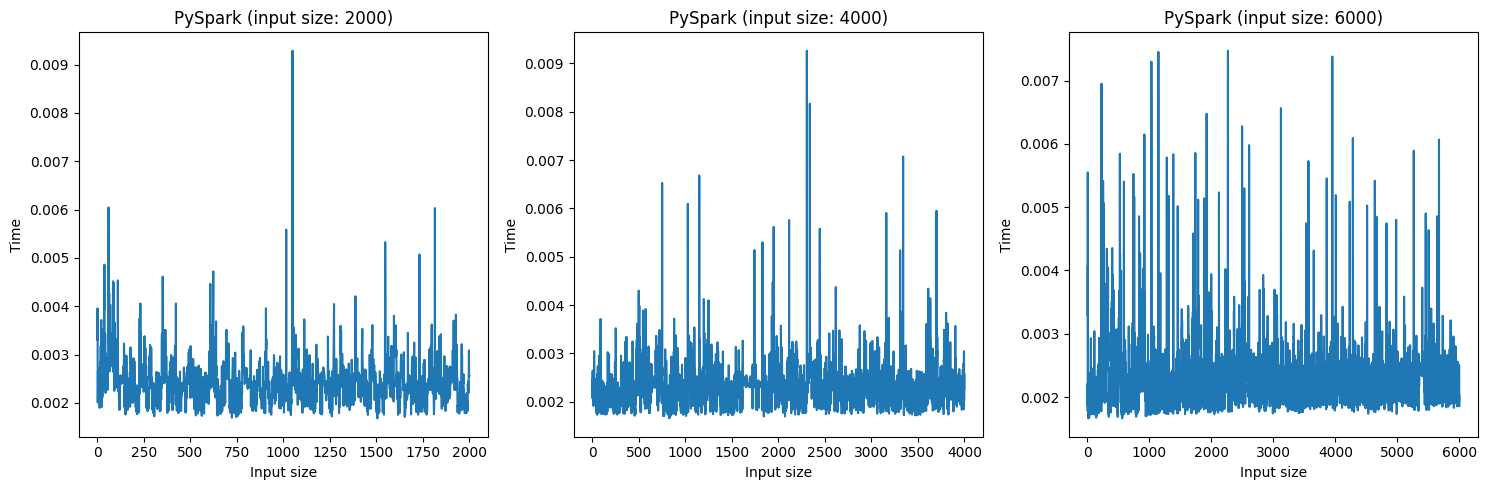

In [9]:
from utils import plotfn

plotfn.time_complexity3_spark(
    distance_udf,
    genjson.dataframe,
    spark,
    "PySpark",
    2000,
    2000
)

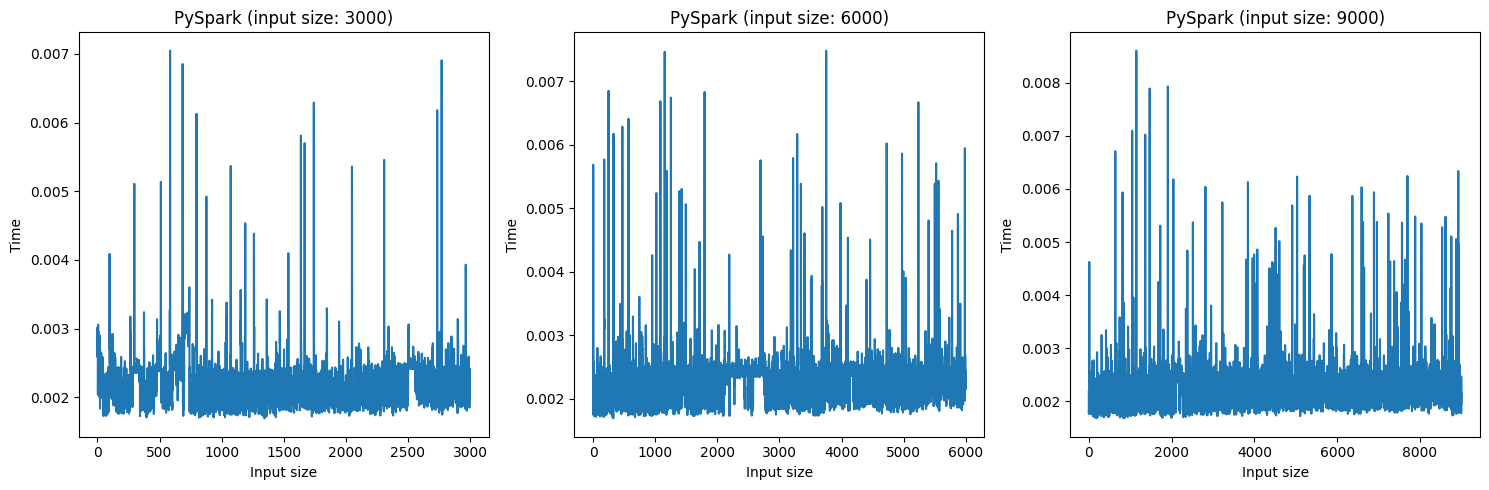

In [10]:
from utils import plotfn

plotfn.time_complexity3_spark(
    distance_udf,
    genjson.dataframe,
    spark,
    "PySpark",
    3000,
    3000
)